In [7]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb
from sklearn.datasets import fetch_mldata
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from skimage.segmentation import quickshift

In [8]:
mnist = fetch_mldata('MNIST original')
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist.data.reshape((-1,28,28))],0)
y_vec = mnist.target.astype(np.uint8)

class PipeStep(object):
    def __init__(self, step_func):
        self._step_func = step_func
    def fit(self, *args):
        return self
    def transform(self, X):
        return self._step_func(X)

makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    ('RF', RandomForestClassifier())
    ])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size = 0.55)
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x111764a50>), ('Flatten Image', <__main__.PipeStep object at 0x111764e90>), ('RF', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impu...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

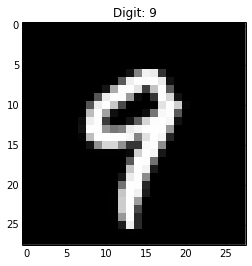

In [9]:
idx = 0
x_i = X_test[idx]
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(x_i, interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_test[idx]))

[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 2 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 4 0 0 0 0 0 2 2 0 0]
 [1 1 1 3 1 1 1 1 1 1 1 1 1 1 4 4 4 1 4 0 0 0 0 0 2 2 2 0]
 [1 1 3 3 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 0 0 0 0 2 2 2 0]
 [1 1 3 3 1 1 1 1 1 1 1 4 4 4 4 4 1 4 4 4 4 4 4 4 4 2 2 2]
 [1 1 3 3 1 1 1 1 1 1 1 4 4 4 1 4 4 4 4 4 4 4 4 4 4 4 2 2]
 [1 1 3 3 1 1 1 1 1 1 1 1 1 4 4 4 4 4 1 4 4 4 4 4 4 4 2 2]
 [1 3 3 3 3 3 3 3 1 1 1 1 1 4 1 4 4 4 4 4 4 4 4 4 4 4 4 2]
 [3 3 3 6 6 6 6 6 6 1 1 1 1 6 6 4 4 1 4 4 4 4 4 4 4 4 4 2]
 [3 3 6 6 6 6 6 6 6 6 6 6 6 6 4 4 4 4 4 4 4 4 4 4 4 4 4 

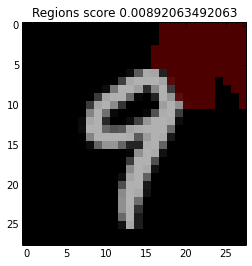

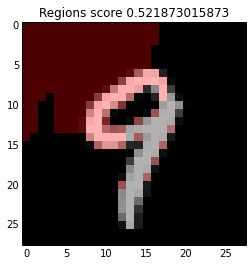

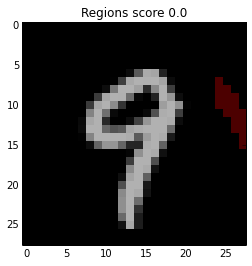

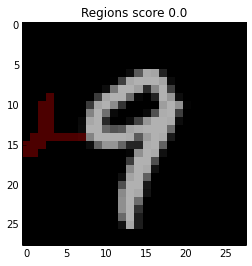

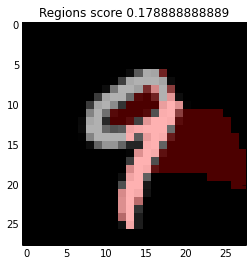

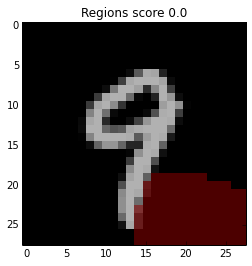

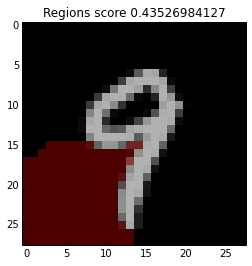

In [10]:
def unary_individual_influence(dataset, cls, x_ind, idx, qs_kernel_size = 1):
    segments = quickshift(x_ind, kernel_size=qs_kernel_size, max_dist=200, ratio=0.2)
    print(segments)
    n_features = np.unique(segments).shape[0]
    y_pred = cls.predict(dataset)
    y_pred[:] = y_pred[idx]

    for f in range(n_features):
        mask = np.zeros(segments.shape).astype(bool)
        mask[segments == f] = True
        X_int = []
        n = dataset.shape[0]
        for i in range(n):
            tmp = copy.deepcopy(x_ind)
            tmp[mask] = dataset[i][mask]
            X_int.append(tmp)
        X_int = np.array(X_int)
        y_pred_inter = cls.predict(X_int)

        local_influence = np.zeros(y_pred_inter.shape[0])
        local_influence = local_influence + (y_pred == y_pred_inter)*1.
        result = 1-(local_influence).mean()
        print("Result for zone",f,":", result)
        
        fig, ax1 = plt.subplots(1,1)
        ax1.imshow(label2rgb(mask,x_ind, bg_label = 0), interpolation = 'nearest')
        ax1.set_title('Regions score {}'.format(result))
        
unary_individual_influence(X_test, simple_rf_pipeline, x_i, idx)